In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, cumulative_trapezoid
from tqdm import tqdm

In [2]:
f_meas = {True:{True:{True:{},\
                      False:{}},\
                False:{True:{},\
                       False:{}}},\
          False:{True:{True:{},\
                       False:{}},\
                 False:{True:{},\
                        False:{}}}}
with open('measured_freqs.txt', 'r') as f:
    ls = f.readlines()
    for l in ls[1:]:
        vals = l.split(',')
        withcap = bool(float(vals[0]))
        pouring = bool(float(vals[1]))
        ending = bool(float(vals[2]))
        ml = float(vals[3])
        freqs = [float(v) for v in vals[4:]]
        f_meas[withcap][pouring][ending][ml] = freqs

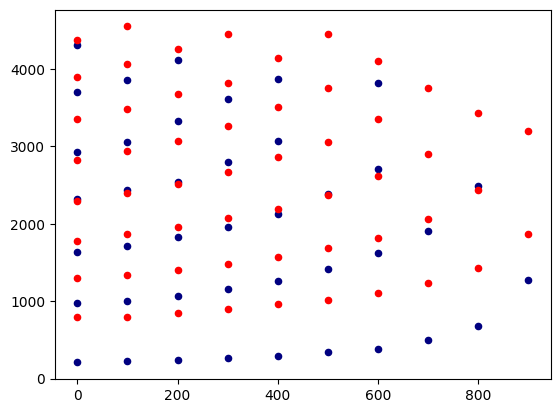

In [3]:
for withcap in [0,1]:
    for pouring in [0,1]:
        for ending in [0,1]:
            for key in f_meas[withcap][pouring][ending].keys():
                freqs = f_meas[withcap][pouring][ending][key]
                color = 'red' if withcap else 'navy'
                alpha = 0 if pouring else 1
                marker = 'x' if ending else 'o'
                s = 40 if ending else 20
                plt.scatter([key]*len(freqs), freqs, s=s, color=color, marker=marker, alpha=alpha)

plt.show()

In [4]:
def find_harmonics(z0, k0, dydz, dk=1e-6, tol=1e-6, maxiter=100):
    q = 1.
    it = 0
    z_eval = np.linspace(z0, 1, 3)
    while np.abs(q) > tol and it < maxiter:
        k = k0
        sol = solve_ivp(dydz, [z_eval.min(),z_eval.max()], [0, 1], t_eval=z_eval, args=(k,))
        q = sol.y[1][-1]
        k = k0 + dk
        sol = solve_ivp(dydz, [z_eval.min(),z_eval.max()], [0, 1], t_eval=z_eval, args=(k,))
        dq = sol.y[1][-1] - q
        k0 = k0 - q / dq * dk # essentially Newton Raphson
        it = it + 1
    return k

## Without cap

In [5]:
cs = 330 # m/s
duration = 10

H = 0.248 # m
Rbase = 0.05 # m
Ropen = 0.0195 # m
def R_z(z): return ((Rbase - Ropen) * (1 - z) + Ropen) / H # conical
def A_z(z): return np.pi * R_z(z)**2.0
    
z_arr = np.linspace(0,1,1000)
B_z = lambda z: np.interp(z, z_arr, np.gradient(np.log(A_z(z_arr)), z_arr))
t = np.linspace(0,duration,300)
V_arr = cumulative_trapezoid(A_z(z_arr), z_arr, initial=0)
Q = 100. / (H**3 * 1e6) # so that each second corresponds to 100 ml
t_arr = V_arr / Q
z0_t = lambda t: np.interp(t, t_arr, z_arr)

def dydz(z, y, k):
    p, q = y
    dpdz = q
    dqdz = -B_z(z) * q - 0.25 * np.pi**2.0 * k**2 * p
    return [dpdz, dqdz]

In [6]:
kn = find_harmonics(z0_t(1), 3, dydz, dk=1e-6, tol=1e-6, maxiter=100)
print(kn, kn * cs / 4. / H)

3.361345438608045 1118.1895108272731


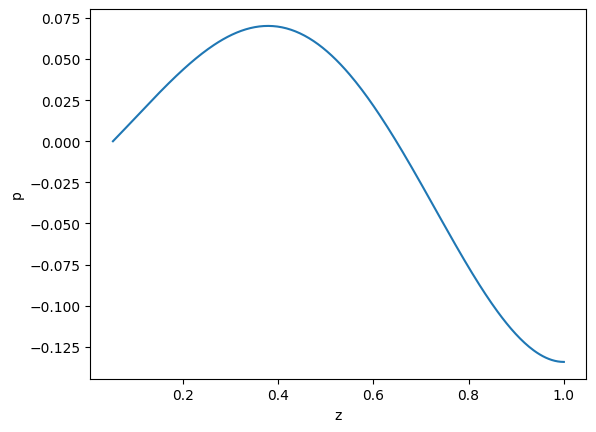

In [7]:
k = 3.3613
z0 = z0_t(1)
z_eval = np.linspace(z0, 1, 300)
sol = solve_ivp(dydz, [z_eval.min(),z_eval.max()], [0, 1./k], t_eval=z_eval, args=(k,))
plt.plot(sol.t, sol.y[0])
plt.xlabel('z')
plt.ylabel('p')
plt.show()

100%|█████████████████████████████████████████████| 7/7 [00:12<00:00,  1.79s/it]


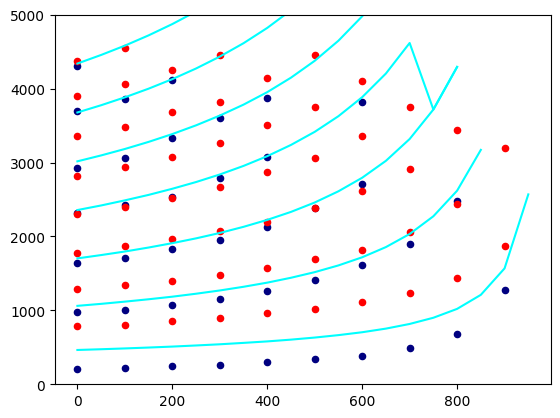

In [8]:
Qin = np.arange(0,1000,50)
f_Qin = Qin * 0
for k_guess in tqdm([1,3,5,7,9,11,13]):
    for i,t in enumerate(Qin / 100.):
        k_guess = find_harmonics(z0_t(t), k_guess, dydz, dk=1e-6, tol=1e-6, maxiter=100)
        f_Qin[i] = cs / 4. / H * k_guess
    plt.plot(Qin[f_Qin > 0], f_Qin[f_Qin > 0], color='cyan')

for withcap in [0,1]:
    for pouring in [0,1]:
        for ending in [0,1]:
            for key in f_meas[withcap][pouring][ending].keys():
                freqs = f_meas[withcap][pouring][ending][key]
                color = 'red' if withcap else 'navy'
                alpha = 0 if pouring else 1
                marker = 'x' if ending else 'o'
                s = 40 if ending else 20
                plt.scatter([key]*len(freqs), freqs, s=s, color=color, marker=marker, alpha=alpha)

plt.ylim(0,5000)
plt.show()

### With cap

In [35]:
cs = 330 # m/s
duration = 10

H = 0.3276 # m
Rbase = 0.05 # m
Ropen = 0.008 # m
def R_z(z): return ((Rbase - Ropen) * (1 - z) + Ropen) / H # conical
def A_z(z): return np.pi * R_z(z)**2.0
    
z_arr = np.linspace(0,1,1000)
B_z = lambda z: np.interp(z, z_arr, np.gradient(np.log(A_z(z_arr)), z_arr))
t = np.linspace(0,duration,300)
V_arr = cumulative_trapezoid(A_z(z_arr), z_arr, initial=0)
Q = 100. / (H**3 * 1e6) # so that each second corresponds to 100 ml
t_arr = V_arr / Q
z0_t = lambda t: np.interp(t, t_arr, z_arr)

def dydz(z, y, k):
    p, q = y
    dpdz = q
    dqdz = -B_z(z) * q - 0.25 * np.pi**2.0 * k**2 * p
    return [dpdz, dqdz]

100%|█████████████████████████████████████████████| 3/3 [00:04<00:00,  1.51s/it]


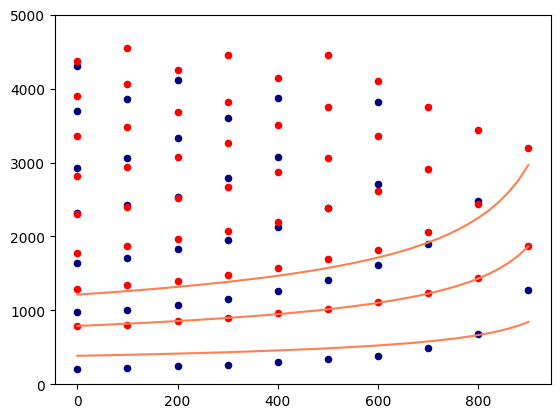

In [37]:
Qin = np.arange(0,920,20)
f_Qin = Qin * 0
for k_guess in tqdm([1,3,5]):#,7,9,11,13,15,17]):
    for i,t in enumerate(Qin / 100.):
        k_guess = find_harmonics(z0_t(t), k_guess, dydz, dk=1e-6, tol=1e-6, maxiter=100)
        f_Qin[i] = 0.9 * cs / 4. / H * k_guess
    plt.plot(Qin[f_Qin > 0], f_Qin[f_Qin > 0], color='coral')

for withcap in [0,1]:
    for pouring in [0,1]:
        for ending in [0,1]:
            for key in f_meas[withcap][pouring][ending].keys():
                freqs = f_meas[withcap][pouring][ending][key]
                color = 'red' if withcap else 'navy'
                alpha = 0 if pouring else 1
                marker = 'x' if ending else 'o'
                s = 40 if ending else 20
                plt.scatter([key]*len(freqs), freqs, s=s, color=color, marker=marker, alpha=alpha)

plt.ylim(0,5000)
plt.show()

* Looks like the lowest order mode is missing from observed data
* Also, the solution for this precise geometry doesn't precisely match the observed data
* It matches something with a slightly smaller opening radius, and with all frequencies scaled down by 0.9.
* Harmonics are pretty much unexplained.

This is good enough to go forward with the bottle itself, since it is still very close to a binary chirp. But needs more work to match the solution and explain all the behaviours.